In [44]:
# Core Libraries for Data Handling and Modeling
import pandas as pd
import numpy as np
import joblib

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for Preprocessing and Model Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

# Model and Interpretability
from xgboost import XGBClassifier
import shap

In [45]:
# Load the dataset
df = pd.read_csv("C:/Users/Subhranil Das/Downloads/heart_disease_uci.csv")

In [46]:
# Initial Data Check
print(df.head())
print(df.info())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  
<class '

In [47]:
# --- Step 1: Process the Target Variable ---
df.dropna(inplace=True)

# Convert the 'num' column to a binary target (0 = No Disease, 1 = Has Disease)
df['target'] = (df['num'] > 0).astype(int)

# --- Step 2: Convert Boolean Columns to Integers ---
# Convert True/False columns to 1/0
df['fbs'] = df['fbs'].astype(int)
df['exang'] = df['exang'].astype(int)

# --- Step 3: One-Hot Encode Categorical Columns ---
# List of categorical columns to encode
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']


In [48]:
# Apply one-hot encoding using pandas get_dummies()
# drop_first=True is used to avoid multicollinearity (dummy variable trap)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --- Step 4: Drop Unnecessary Columns ---
# The original 'num' column, 'id', and 'dataset' are not needed for the model
df = df.drop(['num', 'id', 'dataset'], axis=1)

In [49]:
# --- Final Step: Verify the result ---
# Check the first few rows of the fully numeric DataFrame
print("Cleaned DataFrame Head:")
print(df.head())


Cleaned DataFrame Head:
   age  trestbps   chol  fbs  thalch  exang  oldpeak   ca  target  sex_Male  \
0   63     145.0  233.0    1   150.0      0      2.3  0.0       0      True   
1   67     160.0  286.0    0   108.0      1      1.5  3.0       1      True   
2   67     120.0  229.0    0   129.0      1      2.6  2.0       1      True   
3   37     130.0  250.0    0   187.0      0      3.5  0.0       0      True   
4   41     130.0  204.0    0   172.0      0      1.4  0.0       0     False   

   cp_atypical angina  cp_non-anginal  cp_typical angina  restecg_normal  \
0               False           False               True           False   
1               False           False              False           False   
2               False           False              False           False   
3               False            True              False            True   
4                True           False              False           False   

   restecg_st-t abnormality  slope_flat  slo

In [50]:
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

# Verify the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 748
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    int64  
 1   trestbps                  299 non-null    float64
 2   chol                      299 non-null    float64
 3   fbs                       299 non-null    int64  
 4   thalch                    299 non-null    float64
 5   exang                     299 non-null    int64  
 6   oldpeak                   299 non-null    float64
 7   ca                        299 non-null    float64
 8   target                    299 non-null    int64  
 9   sex_Male                  299 non-null    int64  
 10  cp_atypical angina        299 non-null    int64  
 11  cp_non-anginal            299 non-null    int64  
 12  cp_typical angina         299 non-null    int64  
 13  restecg_normal            299 non-null    int64  
 14  restecg_st-t ab

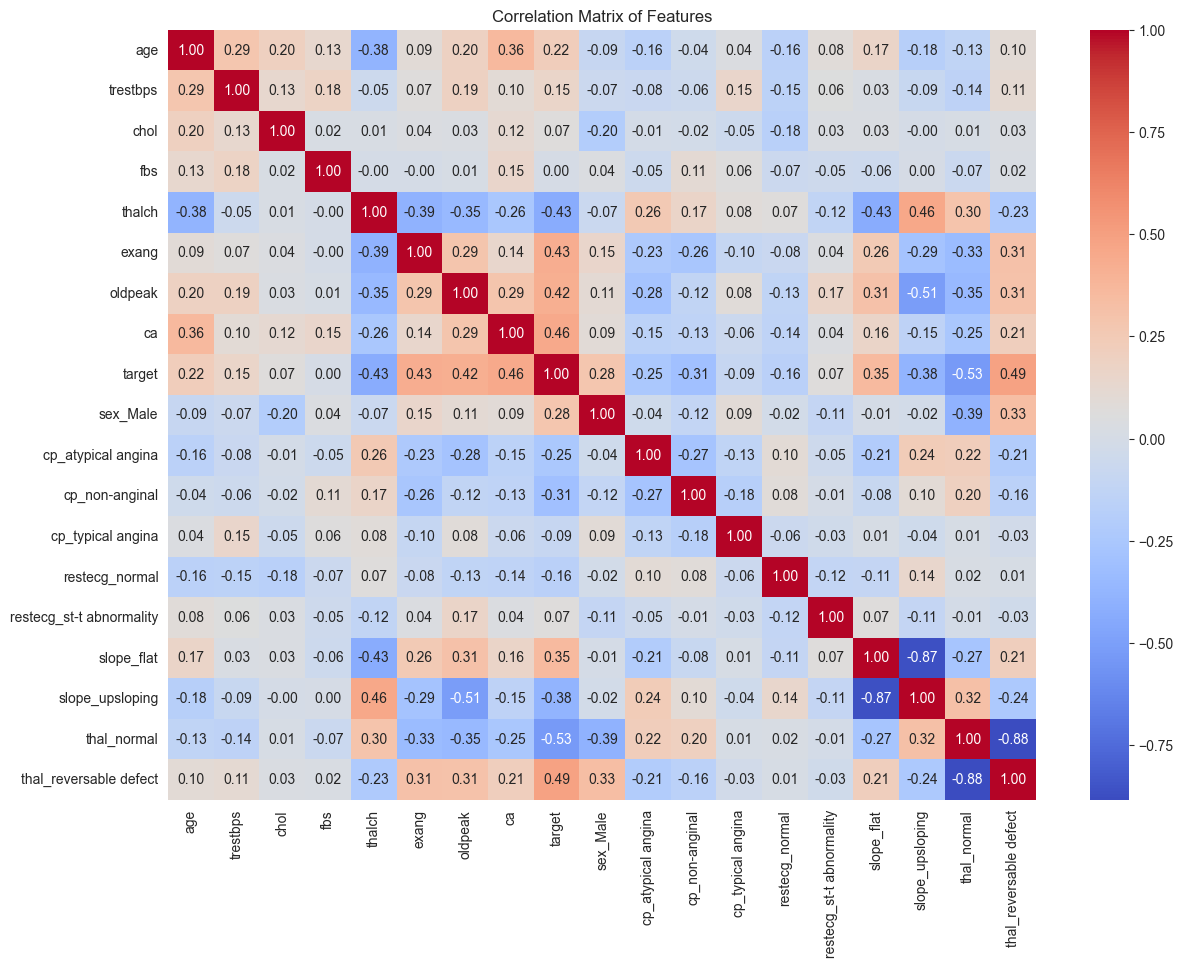

In [51]:
# Set plot style
sns.set_style('whitegrid')

# Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()


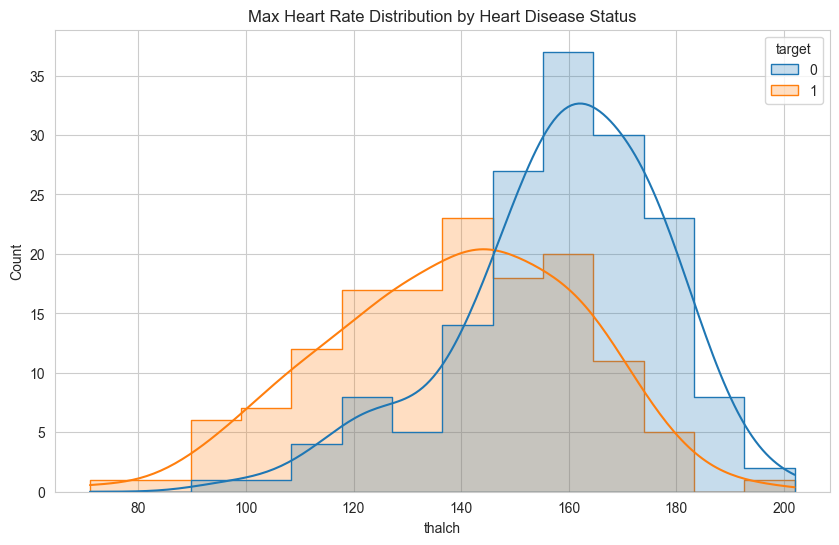

In [52]:
# Distribution of 'thalch' (Max Heart Rate) by target
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='thalch', hue='target', kde=True, element='step')
plt.title('Max Heart Rate Distribution by Heart Disease Status')
plt.show()

In [53]:
# Define features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [54]:
# --- Hyperparameter Tuning with GridSearchCV ---
# Define the XGBoost Classifier
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4, 5]
}

In [55]:
# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5, # 5-fold cross-validation
                           verbose=1)

In [56]:
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.05, 0.1], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [57]:
# Get the best model
best_model = grid_search.best_estimator_
print(f"Best Parameters found: {grid_search.best_params_}")

Best Parameters found: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}


In [58]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


In [59]:
# Print key evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.82
ROC AUC Score: 0.90

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84        32
           1       0.87      0.71      0.78        28

    accuracy                           0.82        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.82      0.82      0.81        60



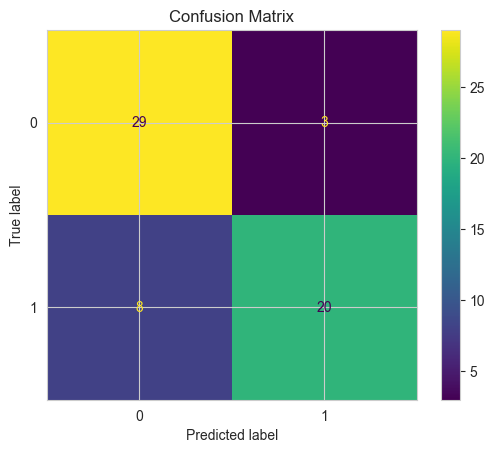

In [60]:
# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

SHAP Summary Plot:


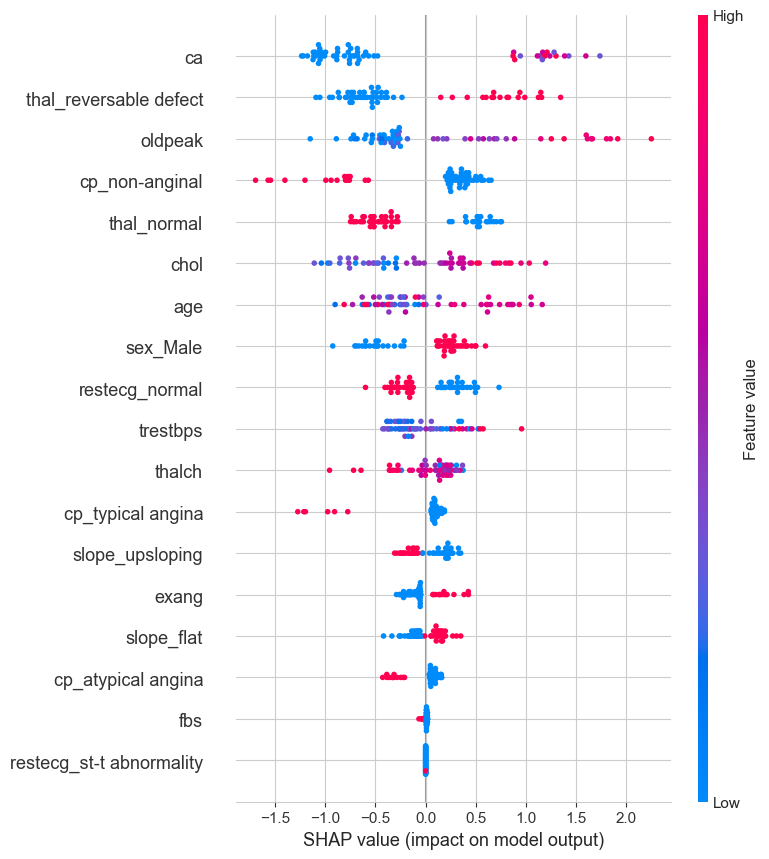

In [61]:
# Initialize the SHAP explainer with our trained model
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Global Feature Importance Plot (shows which features are most important overall)
print("SHAP Summary Plot:")
shap.summary_plot(shap_values, X_test)

In [62]:
# Save the final, trained model to a file
joblib.dump(best_model, 'heart_disease_model.joblib')
print("\nModel saved successfully as 'heart_disease_model.joblib'")


Model saved successfully as 'heart_disease_model.joblib'
